In [20]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline

In [21]:

from locations import Locations
from omegamumu.common.histograms import hist_from_var, multi_hist1d_comparison
from omegamumu.common.plotting import set_lhcb_style, save_fig
from processing import filter_dataframe

# set LHCb style for plots
set_lhcb_style(size=12, grid=True)

# define directories for data and plots
df_dir = Locations.get_df_dir()
plot_dir = Locations.get_plots_dir()
tables_dir = Locations.get_tables_dir()
cond_dir = Locations.get_conditions_dir()

In [22]:
from omegamumu.variables import Var, neutrals
from omegamumu.variables.omegamumu import kintop, pids, pidsgen, bmass_jpsi, bmass_piz, pipipiz_M

from omegamumu.common.histograms import hist_from_var, multi_hist1d_comparison, plot_hist
from omegamumu.selection.selection import xcand_window

In [23]:
omega_cut = xcand_window("omega", "omega", op="&")
eta_cut = xcand_window("omega", "eta", op="&")
omega_cut, eta_cut  

('omega_M>680&omega_M<880', 'omega_M>448&omega_M<648')

In [24]:
from omegamumu.classification import ColumnSelector, ColumnTransformer, load_model

In [25]:
#raredf = pd.read_pickle(f"{df_dir}/omegamumu_rare.pkl")
jpsidf = pd.read_pickle(f"{df_dir}/omegamumu_jpsi.pkl")
mcdf = pd.read_pickle(f"{df_dir}/B2omegaMuMu_omegamumu.pkl")

In [26]:
jpsidf.shape

(689426, 119)

In [27]:
mcdf = filter_dataframe(
    mcdf, "omegamumu", x_cand="omega", xwindow="omega"
)
jpsiomega_df = filter_dataframe(
    jpsidf, "omegamumu", x_cand="omega", xwindow="omega", ismc=False
)

In [28]:
jpsiomega_df.shape

(119503, 119)

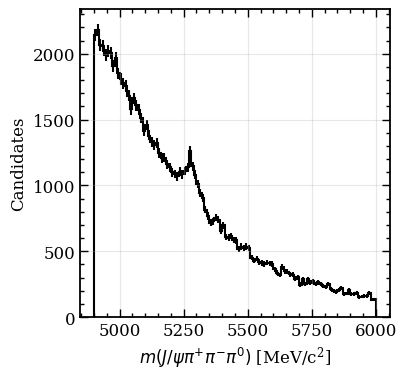

In [30]:
h_bmass_jpsi = hist_from_var(bmass_jpsi, jpsiomega_df)
fig, ax = plt.subplots(figsize=(4, 4))
plot_hist(ax, h_bmass_jpsi)

In [31]:
jpsiomega_df.shape, jpsidf.shape

((119503, 119), (119503, 119))

In [32]:
model = load_model(
    os.path.join(cond_dir, "classification", "omegamumu_reduced_model.json")
) 

In [33]:
vars_data = [
    f  for f in neutrals + kintop + pids
    if f.name in model.feature_names_
]
vars_mc = [
    f  for f in neutrals + kintop + pidsgen
    if f.name in model.feature_names_
]

In [34]:
transformer_data = ColumnTransformer(vars_data)

In [35]:
pipeline_data = Pipeline(steps=[
    ("transformer", transformer_data),
    ("classifier", model),
])

In [36]:
predictions_data = pipeline_data.predict_proba(jpsiomega_df)

In [ ]:
jpsiomega_bdt_df = transformer_data.id_df
jpsiomega_bdt_df["bdt"] = predictions_data[:, 1]

In [38]:
jpsiomega_bdt_df = pd.merge(jpsiomega_df, jpsiomega_bdt_df, on=["runNumber", "eventNumber", "candNumber"], how="inner")

In [39]:
BDT = Var(name="BDT", branch="bdt", label="BDT", x_title="BDT", binning=(50, 0.99, 1))
h_bdt = hist_from_var(BDT, jpsiomega_bdt_df.query("bdt > 0.99"))
fig, ax = plt.subplots(figsize=(4, 4))
plot_hist(ax, h_bdt)

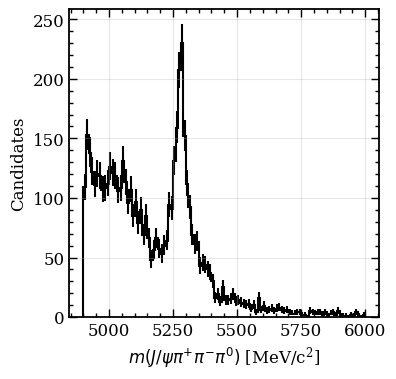

In [40]:
h_jpsiomega = hist_from_var(bmass_jpsi, jpsiomega_bdt_df.query("bdt > 0.99"))
fig, ax = plt.subplots(figsize=(4, 4))
plot_hist(ax, h_jpsiomega)

In [65]:
sig_df = mcdf.query("true_b1g")
sig_df.shape, mcdf.shape

((90958, 172), (296822, 172))

In [66]:
transformer_sig = ColumnTransformer(vars_mc)
pipeline_sig = Pipeline(steps=[
    ("transformer", transformer_sig),
    ("classifier", model),
])
predictions_sig = pipeline_data.predict_proba(sig_df)

In [67]:
sig_bdt_df = transformer_data.id_df
sig_bdt_df["bdt"] = predictions_sig[:, 1]
sig_bdt_df = pd.merge(sig_df, sig_bdt_df, on=["runNumber", "eventNumber", "candNumber"], how="inner")

In [68]:
h_sig_bdt = hist_from_var(BDT, sig_bdt_df.query("bdt > 0.99"))
fig, ax = plt.subplots(figsize=(4, 4))
plot_hist(ax, h_sig_bdt)

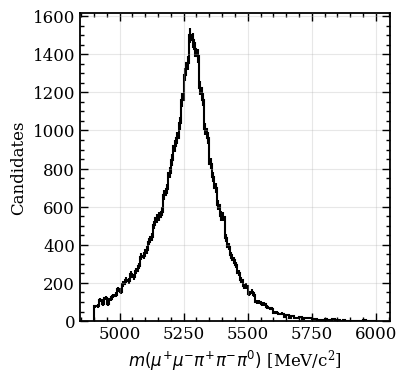

In [73]:
h_sig = hist_from_var(bmass_piz, sig_bdt_df.query("bdt > 0.99"))
fig, ax = plt.subplots(figsize=(4, 4))
plot_hist(ax, h_sig)